# Website A/B Testing - Lab

## Introduction

In this lab, you'll get another chance to practice your skills at conducting a full A/B test analysis. It will also be a chance to practice your data exploration and processing skills! The scenario you'll be investigating is data collected from the homepage of a music app page for audacity.

## Objectives

You will be able to:
* Analyze the data from a website A/B test to draw relevant conclusions
* Explore and analyze web action data

## Exploratory Analysis

Start by loading in the dataset stored in the file 'homepage_actions.csv'. Then conduct an exploratory analysis to get familiar with the data.

> Hints:
    * Start investigating the id column:
        * How many viewers also clicked?
        * Are there any anomalies with the data; did anyone click who didn't view?
        * Is there any overlap between the control and experiment groups? 
            * If so, how do you plan to account for this in your experimental design?

In [1]:
#Your code here
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

df = pd.read_csv('homepage_actions.csv')
df.head()

,timestamp,id,group,action
0,2016-09-24 17:42:27.839496,804196,experiment,view
1,2016-09-24 19:19:03.542569,434745,experiment,view
2,2016-09-24 19:36:00.944135,507599,experiment,view
3,2016-09-24 19:59:02.646620,671993,control,view
4,2016-09-24 20:26:14.466886,536734,experiment,view


In [2]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8188 entries, 0 to 8187
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   timestamp  8188 non-null   object
 1   id         8188 non-null   int64 
 2   group      8188 non-null   object
 3   action     8188 non-null   object
dtypes: int64(1), object(3)
memory usage: 256.0+ KB


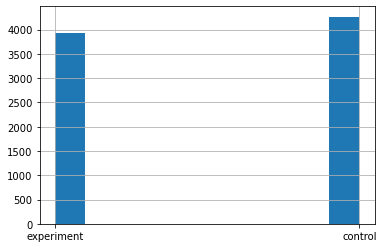

In [5]:
df.group.hist();

In [6]:
df.action.value_counts()

view     6328
click    1860
Name: action, dtype: int64

In [7]:
cids = set(df[df.action=='click']['id'].unique())
vids = set(df[df.action=='view']['id'].unique())
print("Number of viewers: {} \tNumber of clickers: {}".format(len(vids), len(cids)))
print("Number of Viewers who didn't click: {}".format(len(vids-cids)))
print("Number of Clickers who didn't view: {}".format(len(cids-vids)))

Number of viewers: 6328 	Number of clickers: 1860
Number of Viewers who didn't click: 4468
Number of Clickers who didn't view: 0


In [8]:
eids = set(df[df.group=='experiment']['id'].unique())
cids = set(df[df.group=='control']['id'].unique())
print('Overlap of experiment and control groups: {}'.format(len(eids&cids)))

Overlap of experiment and control groups: 0


## Conduct a Statistical Test

Conduct a statistical test to determine whether the experimental homepage was more effective than that of the control group.

In [10]:
#Your code here
df['count'] = 1
df.head()

,timestamp,id,group,action,count
0,2016-09-24 17:42:27.839496,804196,experiment,view,1
1,2016-09-24 19:19:03.542569,434745,experiment,view,1
2,2016-09-24 19:36:00.944135,507599,experiment,view,1
3,2016-09-24 19:59:02.646620,671993,control,view,1
4,2016-09-24 20:26:14.466886,536734,experiment,view,1


In [12]:
control = df[df.group == 'control'].pivot(index = 'id', columns = 'action', values = 'count')
control = control.fillna(value = 0)

experiment = df[df.group == 'experiment'].pivot(index = 'id', columns = 'action', values = 'count')
experiement = experiment.fillna(value = 0)

print("Sample sizes:\tControl: {}\tExperiment: {}".format(len(control), len(experiment)))
print("Total Clicks:\tControl: {}\tExperiment: {}".format(control.click.sum(), experiment.click.sum()))
print("Average click rate:\tControl: {}\tExperiment: {}".format(control.click.mean(), experiment.click.mean()))
control.head()

Sample sizes:	Control: 3332	Experiment: 2996
Total Clicks:	Control: 932.0	Experiment: 928.0
Average click rate:	Control: 0.2797118847539016	Experiment: 1.0


action,click,view
id,,
182994,1.0,1.0
183089,0.0,1.0
183248,1.0,1.0
183515,0.0,1.0
183524,0.0,1.0


In [14]:
import numpy as np
import scipy.stats as stats

def welch_t(a, b):
    
    """ Calculate Welch's t statistic for two samples. """

    numerator = a.mean() - b.mean()
    
    denominator = np.sqrt(a.var(ddof=1)/a.size + b.var(ddof=1)/b.size)
    
    return np.abs(numerator/denominator)

def welch_df(a, b):
    
    """ Calculate the effective degrees of freedom for two samples. This function returns the degrees of freedom """
    
    s1 = a.var(ddof=1) 
    s2 = b.var(ddof=1)
    n1 = a.size
    n2 = b.size
    
    numerator = (s1/n1 + s2/n2)**2
    denominator = (s1/ n1)**2/(n1 - 1) + (s2/ n2)**2/(n2 - 1)
    
    return numerator/denominator


def p_value_welch_ttest(a, b, two_sided=False):
    """Calculates the p-value for Welch's t-test given two samples.
    By default, the returned p-value is for a one-sided t-test. 
    Set the two-sided parameter to True if you wish to perform a two-sided t-test instead.
    """
    t = welch_t(a, b)
    df = welch_df(a, b)
    
    p = 1-stats.t.cdf(np.abs(t), df)
    
    if two_sided:
        return 2*p
    else:
        return p

In [15]:
p_value_welch_ttest(control.click, experiment.click)

0.0

## Verifying Results

One sensible formulation of the data to answer the hypothesis test above would be to create a binary variable representing each individual in the experiment and control group. This binary variable would represent whether or not that individual clicked on the homepage; 1 for they did and 0 if they did not. 

The variance for the number of successes in a sample of a binomial variable with n observations is given by:

## $n\bullet p (1-p)$

Given this, perform 3 steps to verify the results of your statistical test:
1. Calculate the expected number of clicks for the experiment group, if it had the same click-through rate as that of the control group. 
2. Calculate the number of standard deviations that the actual number of clicks was from this estimate. 
3. Finally, calculate a p-value using the normal distribution based on this z-score.

### Step 1:
Calculate the expected number of clicks for the experiment group, if it had the same click-through rate as that of the control group. 

In [17]:
#Your code here
control_rate = control.click.mean()
expected_experiment_clicks_under_null = control_rate * len(experiment)
print(expected_experiment_clicks_under_null)

838.0168067226891


### Step 2:
Calculate the number of standard deviations that the actual number of clicks was from this estimate.

In [18]:
#Your code here
n = len(experiment)
p = control_rate
var = n * p * (1-p)
std = np.sqrt(var)
print(std)

24.568547907005815


In [20]:
actual_experiment_clicks = experiment.click.sum()
z_score = (actual_experiment_clicks - expected_experiment_clicks_under_null)/std
print(z_score)

3.6625360854823588


### Step 3: 
Finally, calculate a p-value using the normal distribution based on this z-score.

In [21]:
#Your code here
import scipy.stats as stats
p_val = stats.norm.sf(z_score) #or 1 - stats.norm.cdf(z_score)
print(p_val)

0.00012486528006951198


### Analysis:

Does this result roughly match that of the previous statistical test?

> Comment: **The experiment page looks like it is more effective. The p-value is < 0.05 so we can reject the null hypothesis. **

## Summary

In this lab, you continued to get more practice designing and conducting AB tests. This required additional work preprocessing and formulating the initial problem in a suitable manner. Additionally, you also saw how to verify results, strengthening your knowledge of binomial variables, and reviewing initial statistical concepts of the central limit theorem, standard deviation, z-scores, and their accompanying p-values.